In [1]:
import pandas as pd

df=pd.read_csv("C:/Users/abhis/yeshwanth/MOVIE-RECOMMENDATION-ENGINE-MLOPS/data/movies_with_images_1.csv")
df.head()

,id,title,overview,genres,cast,director,keywords,rating,vote_count,release_date,imdb_rating,imdb_votes,poster_url,backdrop_url
0,1223601,Sisu: Road to Revenge,Returning to the house where his family was br...,"['Action', 'War']","['Jorma Tommila', 'Stephen Lang', 'Richard Bra...",Jalmari Helander,"['sequel', 'karelia', 'absurd', 'amused']",7.521,282,2025-10-21,NaN,NaN,https://image.tmdb.org/t/p/w500/jNsttCWZyPtW66...,https://image.tmdb.org/t/p/w500/yCatt8lmp3oRFE...
1,1013446,Reflection in a Dead Diamond,When the mysterious woman in the room next doo...,"['Action', 'Thriller', 'Mystery']","['Fabio Testi', 'Yannick Renier', 'Koen De Bou...",Hélène Cattet,[],5.900,48,2025-06-25,NaN,NaN,https://image.tmdb.org/t/p/w500/5CdRxBu7jRDHjt...,https://image.tmdb.org/t/p/w500/AePlQ3osZShJmb...
2,1336189,Delivery Run,A food delivery driver gets caught in a deadly...,"['Action', 'Thriller']","['Alexander Arnold', 'Liam James Collins', 'Jo...",Joey Palmroos,"['winter', 'minnesota', 'wilderness', 'slacker...",5.500,20,2025-09-10,NaN,NaN,https://image.tmdb.org/t/p/w500/eCA5maHDlZtXNT...,https://image.tmdb.org/t/p/w500/hvut2slhhgJ31U...
3,1196067,Worldbreaker,"Five years ago, a tear in the fabric of realit...","['Science Fiction', 'Action']","['Milla Jovovich', 'Luke Evans', 'Meadow Willi...",Brad Anderson,"['monster', 'climate change', 'global warming']",6.129,32,2025-10-30,NaN,NaN,https://image.tmdb.org/t/p/w500/7K8w6mdrJp0oaS...,https://image.tmdb.org/t/p/w500/4mZ06VpfpAPuaU...
4,1439112,Muzzle: City of Wolves,LAPD officer Jake Rosser endeavors to lead a p...,"['Action', 'Thriller', 'Mystery']","['Aaron Eckhart', 'Tanya van Graan', 'Karl Tha...",John Stalberg Jr.,"['police dog', 'lapd']",6.814,43,2025-11-13,NaN,NaN,https://image.tmdb.org/t/p/w500/8qTMRmC07XCGid...,https://image.tmdb.org/t/p/w500/ncI1PlBcANixIk...


In [2]:
df = df.dropna(subset=["overview", "genres", "cast", "director", "keywords"])
print("After cleaning:", df.shape)


After cleaning: (1520, 14)


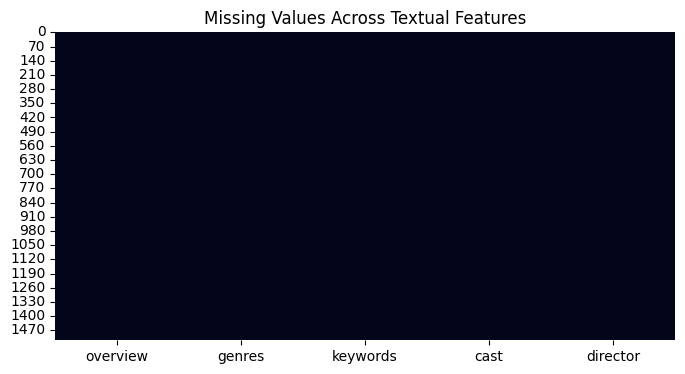

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

text_cols = ["overview", "genres", "keywords", "cast", "director"]

plt.figure(figsize=(8,4))
sns.heatmap(df[text_cols].isnull(), cbar=False)
plt.title("Missing Values Across Textual Features")
plt.show()


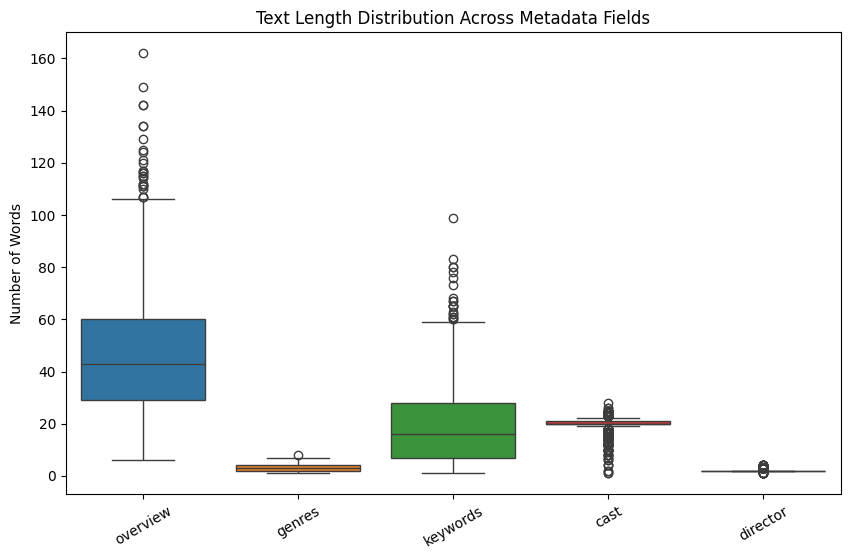

In [4]:
for col in text_cols:
    df[col + "_len"] = df[col].fillna("").apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.boxplot(data=df[[c+"_len" for c in text_cols]])
plt.xticks(range(len(text_cols)), text_cols, rotation=30)
plt.ylabel("Number of Words")
plt.title("Text Length Distribution Across Metadata Fields")
plt.show()


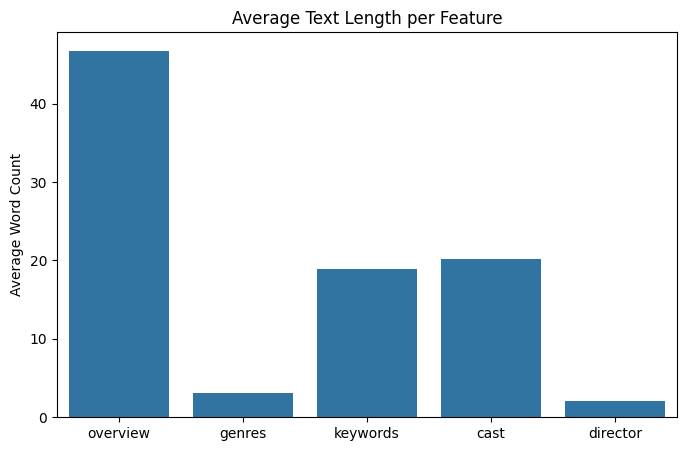

In [5]:
avg_lengths = [df[c+"_len"].mean() for c in text_cols]

plt.figure(figsize=(8,5))
sns.barplot(x=text_cols, y=avg_lengths)
plt.ylabel("Average Word Count")
plt.title("Average Text Length per Feature")
plt.show()


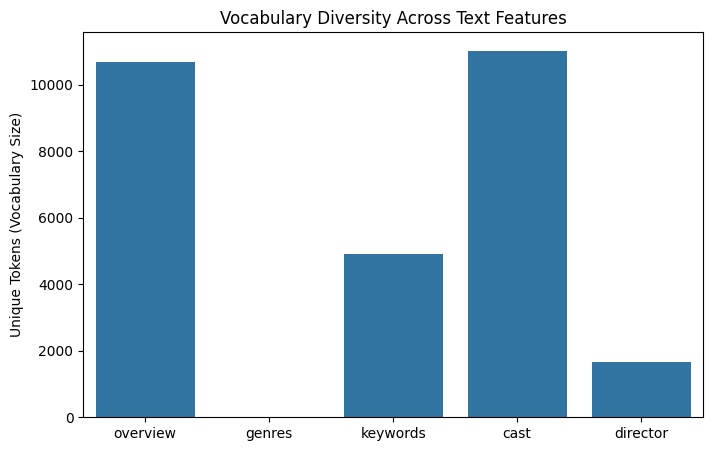

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

def vocab_size(series):
    vec = CountVectorizer(stop_words="english")
    vec.fit(series.fillna(""))
    return len(vec.vocabulary_)

vocab_sizes = [vocab_size(df[col]) for col in text_cols]

plt.figure(figsize=(8,5))
sns.barplot(x=text_cols, y=vocab_sizes)
plt.ylabel("Unique Tokens (Vocabulary Size)")
plt.title("Vocabulary Diversity Across Text Features")
plt.show()


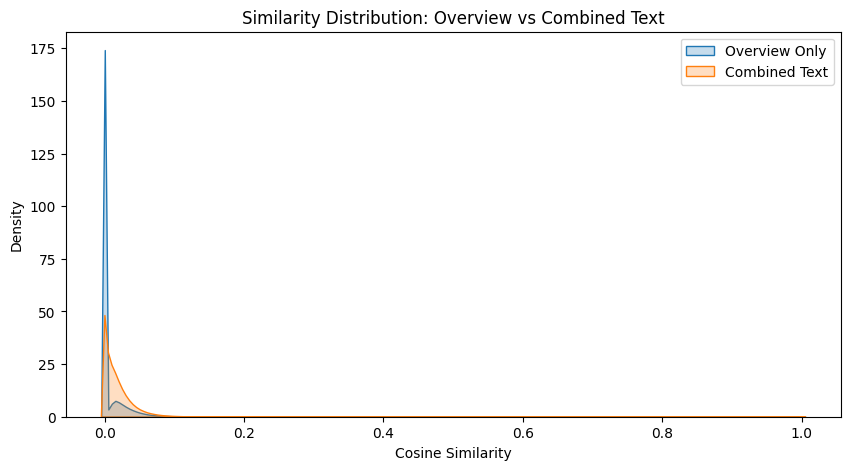

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Overview-only
tfidf_o = TfidfVectorizer(stop_words="english", max_features=5000)
X_o = tfidf_o.fit_transform(df["overview"].fillna(""))
sim_o = cosine_similarity(X_o)

# Combined-text
df["combined_text"] = (
    df["overview"].fillna("") + " " +
    df["genres"].fillna("") + " " +
    df["keywords"].fillna("") + " " +
    df["cast"].fillna("") + " " +
    df["director"].fillna("")
)

tfidf_c = TfidfVectorizer(stop_words="english", max_features=5000)
X_c = tfidf_c.fit_transform(df["combined_text"])
sim_c = cosine_similarity(X_c)

plt.figure(figsize=(10,5))
sns.kdeplot(sim_o.flatten(), label="Overview Only", fill=True)
sns.kdeplot(sim_c.flatten(), label="Combined Text", fill=True)
plt.xlabel("Cosine Similarity")
plt.title("Similarity Distribution: Overview vs Combined Text")
plt.legend()
plt.show()


In [8]:
movie = "bahubali"

matches = df[df["title_norm"].str.contains(movie)]

if len(matches) == 0:
    print("Movie not found in dataset")
else:
    idx = matches.index[0]
    print("Matched movie:", df.loc[idx, "title"])

    top_o = np.argsort(sim_o[idx])[-6:-1]
    top_c = np.argsort(sim_c[idx])[-6:-1]

    print("Overview-only recommendations:")
    print(df.iloc[top_o]["title"].values)

    print("\nCombined-text recommendations:")
    print(df.iloc[top_c]["title"].values)


KeyError: 'title_norm'

In [9]:
import unicodedata

def normalize_text(t):
    if not isinstance(t, str):
        return ""
    t = unicodedata.normalize('NFKD', t).encode('ascii','ignore').decode('utf-8')
    return t.lower().strip()

def join_list(x):
    return " ".join(eval(x)) if isinstance(x, str) and x.startswith("[") else x


In [10]:
df["genres"] = df["genres"].apply(join_list)
df["cast"] = df["cast"].apply(join_list)
df["keywords"] = df["keywords"].apply(join_list)

df["title_norm"] = df["title"].apply(normalize_text)


In [11]:
df['genres']

0                                     Action War
1                        Action Thriller Mystery
2                                Action Thriller
3                         Science Fiction Action
4                        Action Thriller Mystery
                          ...                   
1515                   Animation Fantasy Mystery
1516                               Drama Romance
1517                    Animation Family Fantasy
1518                       Thriller Drama Horror
1519    Fantasy Action Adventure Science Fiction
Name: genres, Length: 1520, dtype: object

In [12]:
df["combined_text"] = (
    df["overview"].fillna("") + " " +
    df["genres"].fillna("") + " " +
    df["keywords"].fillna("") + " " +
    df["cast"].fillna("") + " " +
    df["director"].fillna("")
)


In [13]:
df["combined_text"]

0       Returning to the house where his family was br...
1       When the mysterious woman in the room next doo...
2       A food delivery driver gets caught in a deadly...
3       Five years ago, a tear in the fabric of realit...
4       LAPD officer Jake Rosser endeavors to lead a p...
                              ...                        
1515    In the ruins of a strange city, a young girl t...
1516    A passionate telling of the story of Sada Abe,...
1517    A young witch, on her mandatory year of indepe...
1518    An elite salaryman drunkenly tries to die by s...
1519    When a headstrong street orphan, Seiya, in sea...
Name: combined_text, Length: 1520, dtype: object

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
tfidf_matrix = tfidf.fit_transform(df["combined_text"])

tfidf_matrix.shape


(1520, 5000)

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape


(1520, 1520)

In [16]:
from difflib import SequenceMatcher

def seq_ratio(a, b):
    return SequenceMatcher(None, a, b).ratio()

def jaccard(a_tokens, b_tokens):
    A, B = set(a_tokens), set(b_tokens)
    if not A or not B:
        return 0
    return len(A & B) / len(A | B)

df["title_tokens"] = df["title_norm"].apply(lambda t: t.split())

def find_movie(query):
    q = normalize_text(query)
    q_tokens = q.split()

    # -----------------------------------------
    # SPECIAL CASE: short titles (length <= 4)
    # -----------------------------------------
    if len(q) <= 4:
        # 1. exact normalized match
        exact = df[df["title_norm"] == q]
        if len(exact) > 0:
            return exact["title"].iloc[0]

        # 2. substring match (VERY STRONG)
        sub = df[df["title_norm"].str.contains(q)]
        if len(sub) > 0:
            # pick most popular movie
            return sub.sort_values("vote_count", ascending=False)["title"].iloc[0]

        # 3. prefix match
        pre = df[df["title_norm"].str.startswith(q)]
        if len(pre) > 0:
            return pre.sort_values("vote_count", ascending=False)["title"].iloc[0]

        # 4. last fallback: fuzzy on short titles
        best_title = None
        best_score = 0

        for _, row in df.iterrows():
            t = row["title_norm"]
            score = seq_ratio(q, t)
            if score > best_score:
                best_score = score
                best_title = row["title"]

        return best_title

    # -----------------------------------------
    # MAIN LOGIC for normal-sized titles
    # -----------------------------------------

    # 1. exact match
    exact = df[df["title_norm"] == q]
    if len(exact) > 0:
        return exact["title"].iloc[0]

    # 2. substring match
    sub = df[df["title_norm"].str.contains(q)]
    if len(sub) > 0:
        return sub.sort_values("vote_count", ascending=False)["title"].iloc[0]

    # 3. fuzzy scoring
    best_title = None
    best_score = 0

    for _, row in df.iterrows():
        t = row["title_norm"]
        score = 0.7 * jaccard(q_tokens, row["title_tokens"]) + 0.3 * seq_ratio(q, t)

        if score > best_score:
            best_score = score
            best_title = row["title"]

    return best_title



In [17]:
import numpy as np

# Handle missing values
df["rating"] = df["rating"].fillna(df["rating"].mean())

# Normalize rating 0–1
df["rating_norm"] = (df["rating"] - df["rating"].min()) / (df["rating"].max() - df["rating"].min())


In [18]:
def recommend(movie_input, top_n=10):
    title = find_movie(movie_input)
    if title is None:
        return None

    idx = df.index[df["title"] == title][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    movie_indices = [i[0] for i in sim_scores]
    return df.iloc[movie_indices][["title", "genres", "rating", "poster_url"]]


In [19]:
recommend("doctor")

,title,genres,rating,poster_url
149,Doctor Strange in the Multiverse of Madness,Fantasy Action Adventure,7.235,https://image.tmdb.org/t/p/w500/ddJcSKbcp4rKZT...
63,Spider-Man: No Way Home,Action Adventure Science Fiction,7.936,https://image.tmdb.org/t/p/w500/1g0dhYtq4irTY1...
1151,Thor: Ragnarok,Action Adventure Science Fiction Comedy,7.583,https://image.tmdb.org/t/p/w500/rzRwTcFvttcN1Z...
94,Avengers: Endgame,Adventure Science Fiction Action,8.237,https://image.tmdb.org/t/p/w500/bR8ISy1O9XQxqi...
61,Avengers: Infinity War,Adventure Action Science Fiction,8.235,https://image.tmdb.org/t/p/w500/7WsyChQLEftFiD...
237,Guardians of the Galaxy Vol. 2,Science Fiction Adventure Action,7.611,https://image.tmdb.org/t/p/w500/y4MBh0EjBlMuOz...
223,The Marvels,Science Fiction Adventure Action,5.955,https://image.tmdb.org/t/p/w500/9GBhzXMFjgcZ3F...
101,Spider-Man: Homecoming,Action Adventure Science Fiction,7.329,https://image.tmdb.org/t/p/w500/c24sv2weTHPsmD...
31,The Fantastic 4: First Steps,Science Fiction Adventure Action,7.009,https://image.tmdb.org/t/p/w500/abqOz6EL3yXyOO...
135,Guardians of the Galaxy Vol. 3,Science Fiction Adventure Action,7.931,https://image.tmdb.org/t/p/w500/r2J02Z2OpNTctf...


In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

def evaluate_recommender(k=10):
    tp = fp = fn = 0
    n = len(df)

    for idx in range(n):
        # Ground truth (pure cosine)
        true_scores = sorted(
            list(enumerate(cosine_sim[idx])),
            key=lambda x: x[1],
            reverse=True
        )[1:k+1]
        true_indices = [i[0] for i in true_scores]

        # Predictions (pure cosine)
        title = df.iloc[idx]["title"]
        pred_df = recommend_pure(title, k)
        if pred_df is None:
            continue

        pred_indices = [df.index[df["title"] == t][0] for t in pred_df["title"]]

        true_vec = np.zeros(n)
        pred_vec = np.zeros(n)
        true_vec[true_indices] = 1
        pred_vec[pred_indices] = 1

        tp += np.sum((true_vec == 1) & (pred_vec == 1))
        fp += np.sum((true_vec == 0) & (pred_vec == 1))
        fn += np.sum((true_vec == 1) & (pred_vec == 0))

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"Precision@{k}: {precision:.4f}")
    print(f"Recall@{k}: {recall:.4f}")
    print(f"F1-score@{k}: {f1:.4f}")


In [21]:
evaluate_recommender(k=10)


NameError: name 'recommend_pure' is not defined

In [22]:
def genre_precision_at_k(k=10):
    total = 0
    match = 0

    for idx in range(len(df)):
        title = df.iloc[idx]["title"]
        genres = set(df.iloc[idx]["genres"].split())

        preds = recommend(title, top_n=k)
        if isinstance(preds, str):
            continue

        for _, row in preds.iterrows():
            total += 1
            rec_genres = set(row["genres"].split())
            if len(genres & rec_genres) > 0:
                match += 1

    precision = match / total
    print(f"Genre Precision@{k}: {precision:.4f}")
    return precision


In [23]:
genre_precision_at_k(10)


Genre Precision@10: 0.8174


0.8174342105263158

In [24]:
import os
import pickle
import numpy as np
from scipy import sparse

# Get current working directory (notebook folder)
BASE_DIR = os.getcwd()
print("Saving files to:", BASE_DIR)

# File paths
DF_PATH = os.path.join(BASE_DIR, "df_movies.csv")
TFIDF_PATH = os.path.join(BASE_DIR, "tfidf_vectorizer.pkl")
TFIDF_MATRIX_PATH = os.path.join(BASE_DIR, "tfidf_matrix.npz")
COSINE_SIM_PATH = os.path.join(BASE_DIR, "cosine_similarity.npy")

# Save dataframe
df.to_csv(DF_PATH, index=False)

# Save TF-IDF vectorizer
with open(TFIDF_PATH, "wb") as f:
    pickle.dump(tfidf, f)

# Save TF-IDF matrix (sparse)
sparse.save_npz(TFIDF_MATRIX_PATH, tfidf_matrix)

# Save cosine similarity matrix (optional)
np.save(COSINE_SIM_PATH, cosine_sim)

print("✅ All artifacts saved successfully in current directory.")


Saving files to: c:\Users\abhis\yeshwanth\MOVIE-RECOMMENDATION-ENGINE-MLOPS\notebook
✅ All artifacts saved successfully in current directory.
